# Topic modeling of English-language sessions of classical and contemporary therapists

**Data:** The primary source material consisted of publicly available recordings of psychotherapeutic sessions posted on YouTube. In addition, textual transcripts of Carl Rogers' sessions were used. The materials were divided into two datasets: sessions conducted by classical and by modern therapists. The sample of classical psychotherapeutic sessions includes 25 transcripts and recordings, while the sample of modern sessions comprises 97 ones. Classical therapists are represented by session transcripts and recordings of the founders of therapeutic schools – Carl Rogers, Fritz Perls, and Albert Ellis – while modern therapists are represented by recordings of 37 unique practitioners. The samples of classical and modern psychotherapeutic sessions involved 22 and 66 unique clients, respectively.

**Purporse** is to conduct and compare topic modeling of therapeutic sessions between modern and classical therapists

**Methods**: The BERTopic text data topic modeling library was used in the research process. Pre-trained embeddings from the Sentence-Transformer model 'paraphrase-multilingual-MiniLM-L12-v2' were used to create a vector space. UMAP (Uniform Manifold Approximation and Projection) method was applied to reduce the vector space's dimensionality, and HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) was used to cluster the data. The topic representation of the clusters was made using BERTopic's built-in c-TF-IDF method for assessing the importance of words within the context of document clusters, and its optimization was primarily achieved through the use of large language models like GPT.

**Tasks:**
- Perform preprocessing of the therapeutic session corpora, differentiating between modern and classical therapists.
- Construct a vector space from the processed corpora.
- Implement dimensionality reduction on the vector space.
- Conduct clustering analysis on the resulting vector space.
- Generate topic representations.
- Assess and optimize the identified topic structures within therapeutic sessions from modern and classical therapists.
- Compare the topic structures derived from the therapeutic sessions.




In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install gensim
!pip install openai
!pip install datamapplot

In [ ]:
%%capture

import pandas as pd
import numpy as np
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm

import re
import string
import os
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('russian'))
import spacy
nlp_en = spacy.load("en_core_web_sm")

import collections
from collections import defaultdict
#import gensim.corpora as corpora
#from gensim.models.coherencemodel import CoherenceModel
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer

import openai
import datamapplot

In [ ]:
%%capture
!pip install bertopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic

In [ ]:
%%capture
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

In [ ]:
%%capture
#!pip install umap
!import umap
from umap import UMAP

#!pip install hdbscan
from hdbscan import HDBSCAN

/bin/bash: line 1: import: command not found


In [ ]:
df_classic = pd.read_excel('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/Classic_sessions.xlsx')
df_modern = pd.read_excel('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/Modern_sessions.xlsx')
display(df_classic)
display(df_modern)

file_name speaker_ru  \
0                089.xlsx     клиент   
1                089.xlsx   терапевт   
2                089.xlsx     клиент   
3                089.xlsx   терапевт   
4                089.xlsx     клиент   
...                   ...        ...   
17289  rogers_v2-v17.xlsx     клиент   
17290  rogers_v2-v17.xlsx   терапевт   
17291  rogers_v2-v17.xlsx     клиент   
17292  rogers_v2-v17.xlsx   терапевт   
17293  rogers_v2-v17.xlsx     клиент   

                                                  speech  \
0                                     Сразу же. Я боюсь.   
1      Но ты улыбаешься на другой вечеринке, но долже...   
2      И также подозрительна к тебе, я думаю, ты прек...   
3                          Но у вас есть четвертый этап.   
4      Я не знаю. Я в основном знаю о тебе. Боюсь, чт...   
...                                                  ...   
17289                                          (Кашель).   
17290           Я вижу, что наше время подходит к концу.   
17291      (Улыбается) Я не понимаю (не слышно), хорошо.   
17292  Это кажется вам очень загадочным. Вы испытали ...   
17293                                Да. (Ноги и улыбки)   

                                               speech_en  
0                                Right away. I'm scared.  
1      Are you say you're scared? But you're smiling ...  
2      And also suspicious of you I think you underst...  
3                                  But you have stage 4.  
4      I don't know. I'm mostly aware of you. I'm afr...  
...                                                  ...  
17289                                          (Coughs).  
17290               I see our time is about up.        -  
17291      (Smiles) I don't understand (Inaudible) okay.  
17292    It seems very mysterious to you. You've expe...  
17293                             Yes. (Nods and smiles)  

[17294 rows x 4 columns]

file_name speaker_ru  \
0     101.1.xlsx   терапевт   
1     101.1.xlsx     клиент   
2     101.1.xlsx   терапевт   
3     101.1.xlsx     клиент   
4     101.1.xlsx   терапевт   
...          ...        ...   
7916    340.xlsx     клиент   
7917    340.xlsx   терапевт   
7918    340.xlsx   терапевт   
7919    340.xlsx     клиент   
7920    340.xlsx   терапевт   

                                                 speech  \
0     Я знаю, когда мы встретились в последний раз д...   
1     Да, так в школе. Я учился в школе, и мы должны...   
2     Таймер для того, как недавно, когда тебе пришл...   
3     Да, я имею в виду, как раньше и это раньше в м...   
4     Так что эта презентация, которую ты дал с текс...   
...                                                 ...   
7916  Я думаю, что это обычно для меня, когда я очен...   
7917                            Да, я очень благодарен.   
7918  Ваша честность и все то, что вы сказали в ваше...   
7919  Да, я пытался, и так как мне плохо говорить "х...   
7920  Хорошо. Спасибо большое и желаю вам всего наил...   

                                              speech_en  
0     I know when we met last time for your intake. ...  
1     Yes, so in school.  I am in school for teachin...  
2     A timer for like recently when you had to get ...  
3     yeah, I mean like before and it earlier in my ...  
4     So this presentation that you gave with the ly...  
...                                                 ...  
7916  kind of a difficult question for me because I ...  
7917                        Yeah, I am really grateful.  
7918  Your honesty and all that rain gauge as you sa...  
7919  Yeah, I mean, I I did try and since I'm sick t...  
7920  Okay. Thank you so much and wish you all the b...  

[7921 rows x 4 columns]

###  Text Сorpora Preprocessing

Selecting a text corpora::

In [ ]:
df_classic_text = df_classic.loc[df_classic.speaker_ru=='терапевт', 'speech_en'].reset_index(drop=True)
print('CLASSIC SESSIONS:')
print('Количество строк:', df_classic_text.shape[0])
display(HTML(pd.DataFrame(df_classic_text.head()).to_html()))

print()

df_modern_text = df_modern.loc[df_modern.speaker_ru=='терапевт', 'speech_en'].reset_index(drop=True)
print('MODERN SESSIONS:')
print('Количество строк:', df_modern_text.shape[0])
display(HTML(pd.DataFrame(df_modern_text.head()).to_html()))

CLASSIC SESSIONS:
Количество строк: 8641



MODERN SESSIONS:
Количество строк: 4058


#### Split into sentences

In [ ]:
# remove comments in brackets (e.g. '(pause 10 sec)') otherwise a split with the sentence in brackets may occur
df_classic_text = df_classic_text.apply(lambda text: re.sub(r"\(.*?\)", '', text))
df_modern_text = df_modern_text.apply(lambda text: re.sub(r"\(.*?\)", '', text))

In [ ]:
# Function for Split statements into sentences
def spit_on_sentences(df, batch_size=32):
    df_sentences = []
    for doc in nlp_en.pipe(df.astype(str), batch_size=batch_size, n_process=-1):
        for sent in list(doc.sents):
            df_sentences.append(str(sent))

    return pd.Series(df_sentences)

In [ ]:
df_classic_sentences = spit_on_sentences(df_classic_text)
df_modern_sentences = spit_on_sentences(df_modern_text)

In [ ]:
'''
df_classic_sentences = spit_on_sentences(df_classic_text)
df_modern_sentences = spit_on_sentences(df_modern_text)

df_classic_sentences.to_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_classic_sentences.csv')
df_modern_sentences.to_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_modern_sentences.csv')
'''

df_classic_sentences = pd.read_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_classic_sentences.csv',  index_col=0).iloc[:,0]
df_modern_sentences = pd.read_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_modern_sentences.csv',  index_col=0).iloc[:,0]

display(df_classic_sentences.head())
display(df_modern_sentences.head())

#### Remove abbreviations

In [ ]:
stopwords =  []  #stopwords are not needed for BERTopic

# Function for replacing abbreviations of modal verbs with full forms, the particle 'not', numbers, filtering by stop words.

def replace_modal_verb_contractions(text):
    doc = nlp_en(text)
    new_tokens = []
    for i, token in enumerate(doc):
        if (token.pos_ == "AUX" or token.pos_ == 'PART') and token.lemma_ in ["will", "would", "can", "could", "may", "might", "must", "shall", "should", 'not', 'be', 'have', 'do']:

            if token.text == "'d":
            #  Deciphering Past Perfect auxiliary verb 'had'
                if doc[i+1].tag_ == 'VBN' or doc[i+1].tag_ == 'VBD':
                   new_tokens.append('had')
            #  Deciphering Modal Verb "Would"
                else:
                    new_tokens.append(token.lemma_)
            #  Deciphering other Modal Verbs "will", "can"and particle 'not'
            elif token.text in ["'ll", "’ll", 'ca', 'wo', "n't", "n’t", "'ve", "’ve"]:
                new_tokens.append(token.lemma_)

            elif  token.lemma_ == 'have':
                if token.text in ["'ve", "’ve"]:
                    new_tokens.append('have')
                elif token.text == "'s" or token.text == "’s":
                    new_tokens.append('has')

            #  Deciphering Modal Verb "be"
            elif  token.lemma_ == 'be':
                if token.text == "'m":
                    new_tokens.append('am')
                elif token.text == "'re":
                    new_tokens.append('are')
                elif token.text == "'s":
                    new_tokens.append('is')

            #  Other Verbs Not Requiring Deciphering
            else:
                new_tokens.append(token.text)

       #  Remaining tokens if not in stoplist
        else:
            if token.lemma_ not in stopwords:
                new_tokens.append(token.text)
    return " ".join(new_tokens)

In [ ]:
def modal_verb_solver(df):
    expanded_text  = []
    for doc in nlp_en.pipe(df.astype(str), batch_size=32, n_process=-1):
        expanded_text.append(replace_modal_verb_contractions(doc))

    return pd.Series(expanded_text)

In [ ]:
df_classic_processed = modal_verb_solver(df_classic_sentences)
df_modern_processed = modal_verb_solver(df_modern_sentences)

Process Process-9:
Process Process-10:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/spacy/language.py", line 2420, in _apply_pipes
    sender.send(data)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 421, in _send_bytes
    self._send(buf)
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, 

KeyboardInterrupt: 

In [ ]:
'''
df_classic_processed = modal_verb_solver(df_classic_sentences)
df_modern_processed = modal_verb_solver(df_modern_sentences)

df_classic_processed.to_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_classic_processed.csv')
df_modern_processed.to_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_modern_processed.csv')
'''

df_classic_processed = pd.read_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_classic_processed.csv',  index_col=0).iloc[:,0]
df_modern_processed = pd.read_csv('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/df_modern_processed.csv',  index_col=0).iloc[:,0]

display(HTML(pd.DataFrame(df_classic_processed.sample(5)).to_html()))
display(HTML(pd.DataFrame(df_modern_processed.sample(5)).to_html()))

#### Normalization

In [ ]:
# Making a list of 'mhm' (Rogers sessions)
mhm_list = ['mhm',  'Uhm', 'hmm', 'Mmm', 'M-hm' , 'Uhm' , 'hmm'  , 'huh' , 'uhmhmm', 'uh' , 'oh'  ,
'mhmmm' , 'mhmm',  'ummhmm', 'ummm', 'mm', 'uhmhmm',  'mmh',  'yamhm', 'mmhm',
 'umhm', 'hm' , 'mmmm', 'hmmm', 'mhm', 'mhmmhm', 'mhmm', 'mhmmm', 'mhm', 'hmm', 'mhmhm', 'hhm', 'um', 'm']
mhm_list = [word.lower() for word in mhm_list]
mhm_list = sorted(set(mhm_list))
print(mhm_list)

['hhm', 'hm', 'hmm', 'hmmm', 'huh', 'm', 'm-hm', 'mhm', 'mhmhm', 'mhmm', 'mhmmhm', 'mhmmm', 'mm', 'mmh', 'mmhm', 'mmm', 'mmmm', 'oh', 'uh', 'uhm', 'uhmhmm', 'um', 'umhm', 'ummhmm', 'ummm', 'yamhm']


In [ ]:
def text_normalization(df, df_init):

    # removing question numbers (e.g. C23, S45), converting to lower case
    df = df.apply(lambda text: re.sub(r"c\d+|s\d+", ' ', str(text).lower()))

    # bringing to a single style "okay"
    df = df.apply(lambda text: re.sub(r"o\.k\.|\bok\b", 'okay ', text))

    # removing comments in brackets (e.g. '(pause 10 sec)')
    df = df.apply(lambda text: re.sub(r"\(.*?\)", '', text))

    # removing unrecognized contractions of the modal verb 'is' from the previous stage
    df = df.apply(lambda text: re.sub(r"'s\b", 'is', text))

    # keeping only letters and question/exclamation marks
    df = df.apply(lambda text: re.sub(r"[^a-zA-Z!? ]", ' ', str(text)))

    # removing extra spaces
    df = df.apply(lambda text: " ".join(text.split()))

    # making the 'mhm' list more consistent
    pattern = r"\b(" + "|".join(mhm_list) + r")\b"

    df = df.apply(lambda text: re.sub(pattern, 'mhm', text))

    # removing extra spaces again
    df = df.apply(lambda text: re.sub(r"[^a-zA-Z1!? ]", ' ', str(text)))

    # removing extra spaces
    print ('Number of empty lines removed: ', df_init.shape[0] - df_init[df != ''].shape[0])
    df_init = df_init[df != ''].reset_index(drop=True)
    df = df[df != ''].reset_index(drop=True)

    return df, df_init

In [ ]:
df_classic_norm, df_classic_sentences2 = text_normalization(df_classic_processed, df_classic_sentences)
df_modern_norm, df_modern_sentences2 = text_normalization(df_modern_processed, df_modern_sentences)

Количество удаленных пустых строк:  1199
Количество удаленных пустых строк:  5


In [ ]:
print(df_classic_norm.shape)
display(df_classic_norm.sample(5))
print()
print(df_modern_norm.shape)
display(df_modern_norm.sample(5))

(13725,)


560     i understand that it is simply a conviction th...
9285                                              mhm mhm
3942    you have raised that question but it seems to ...
1379                                                  yes
226     well as you probably know from adam and huntin...
Name: 0, dtype: object


(12519,)


2519     and so a very simple way just to self dude wit...
3244      if i think i will never get better remind myself
7877                                                  yeah
5077     so you did not see the one that you know to him ?
10250    if you got to the boat load analogy that each ...
Name: 0, dtype: object

## BERTopic Pipeline

#### Embedding model

In [ ]:
# embeddings Classic
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

'''
embeddings_classic = embedding_model.encode(df_classic_norm, show_progress_bar=True)
np.save('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/embeddings_classic.npy', embeddings_classic)
'''
Алгоритм снижения размерности векторного пространства
embeddings_classic = np.load('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/embeddings_classic.npy')

In [ ]:
# embeddings Modern

'''
embeddings_modern = embedding_model.encode(df_modern_norm, show_progress_bar=True)
np.save('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/embeddings_modern.npy', embeddings_modern)
'''

embeddings_modern = np.load('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/embeddings_modern.npy')

#### Vector space dimensionality reduction algorithm (UMAP).

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

#### Clustering (HDBSCAN)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


####  Topic Representation Selection

In [ ]:
# Improving the default topic representation by ignoring stop words, high frequency words and using n-grams
vectorizer_model = CountVectorizer(stop_words=stop_words, min_df=2, ngram_range=(1, 2))

In [ ]:
from bertopic.representation import OpenAI

# KeyBERT - A method that derives inspiration from how KeyBERT works
keybert_model = KeyBERTInspired()

# Part-of-Speech - Using SpaCy's POS tagging to extract words
pos_model = PartOfSpeech("ru_core_news_md")

# MMR - Diversify the topic words
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# OpenAI - Use ChatGPT to label our topics
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
Topic must be in the language in which the documents are written
"""
client = openai.OpenAI(api_key='sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
openai_model = OpenAI(client, model="gpt-4o-mini", exponential_backoff=True, chat=True, prompt=prompt, nr_docs=20)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,
    "MMR": mmr_model,
    "POS": pos_model
}

Let's write a function to calculate coherence and output the most relevant documents for each topic.

In [ ]:
# Function to calculate coherence and output the most relevant documents for each topic

def bertopic_analysis(topic_model, preproc_docs, orig_docs, nr_repr_docs=10, coherence_calculation=True):

# Coherence calculation:

    if coherence_calculation==True:
        cleaned_docs = topic_model._preprocess_text(preproc_docs)
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topics = topic_model.get_topics().copy()
        topics.pop(-1, None)
        topic_words = [
            [word for word, _ in topic_model.get_topic(topic) if word != ""] for topic in topics
        ]

        coherence_model = CoherenceModel(topics=topic_words,
                                      texts=tokens,
                                      corpus=corpus,
                                      dictionary=dictionary,
                                      coherence='c_v')
        coherence = coherence_model.get_coherence()

        print()
        print('\033[1m' + 'Когерентность тематик модели:' +'\033[0m', coherence)
        print()


#  Brief information about the topics:

    topic_model_info = topic_model.get_topic_info()
    topic_model_info = topic_model_info[['Topic', 'Count', 'CustomName', 'Name']]
    topic_model_info.columns = ['Topic', 'Count', 'OpenAI_name', 'BERTopic_ame']
    print()
    print('\033[1m' + 'Краткая информации о тематиках:' +'\033[0m')
    print()
    print(tabulate(topic_model_info, headers='keys', tablefmt='presto'))
    print()


# Preparing the most relevant documents for output:
    documents = pd.DataFrame({"Document": preproc_docs,
                              "ID": range(len(preproc_docs)),
                              "Topic": topic_model.topics_,
                              "Image": None})
    repr_d_map, repr_docs, repr_doc_ind, repr_doc_ids = topic_model._extract_representative_docs(topic_model.c_tf_idf_, documents, topic_model.topic_labels_, nr_repr_docs=nr_repr_docs)


    data_ids = defaultdict(list)

    for ind, ids in enumerate(repr_doc_ids):
      # print(ind, ids)
      for el_ids in ids:
        orig_texts = orig_docs[el_ids]

        data_ids['Topic'].append(ind-1)
        data_ids['Ids_topic'].append(el_ids)
        data_ids['orig_text'].append(orig_texts)

    df_with_ids = pd.DataFrame(dict(data_ids))

# Printing the most relevant documents:

    for i in (df_with_ids.Topic.unique()):
      print('\033[1m' + f'TOPIC_{i}' + '\033[0m')
      print('\033[1m' + 'Количество текстов: ' + '\033[1m', topic_model_info.Count[i+1])
      print('\033[1m' + 'Название: ' + '\033[1m', topic_model_info.OpenAI_name[i+1])
      print('\033[1m' + 'Ключевые слова:' + '\033[0m', ([word for word, _ in topic_model.get_topic(i)][:10]))
      print()
      print('\033[1m' + "Наиболее релевантные тексты:" + '\033[0m')
      for j in range(df_with_ids[df_with_ids.Topic == i].shape[0]):
        if j < nr_repr_docs:    # This is a mandatory condition here because "lemmatization" often results in a large number of documents with identical content, and thus identical relevance to the topic. Consequently, the _extract_representative_docs function retrieves all of them, even though nr_repr_docs is intended to limit the output
            print('{}: {}'.format(df_with_ids[df_with_ids.Topic == i].iloc[j,1], df_with_ids[df_with_ids.Topic == i].iloc[j,2]))
        else:
            break
      print()

## Topic Modeling of Classical Therapists

In [ ]:
%%time
#https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.visualize_hierarchy

topic_model_classic = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  calculate_probabilities=True
)

# Train model
topics, probs = topic_model_classic.fit_transform(df_classic_norm, embeddings_classic)

2025-04-05 11:13:32,164 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-05 11:14:16,744 - BERTopic - Dimensionality - Completed ✓
2025-04-05 11:14:16,747 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-05 11:14:24,588 - BERTopic - Cluster - Completed ✓
2025-04-05 11:14:24,598 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 97/97 [01:10<00:00,  1.38it/s]
2025-04-05 11:16:52,949 - BERTopic - Representation - Completed ✓


CPU times: user 2min 7s, sys: 1.65 s, total: 2min 9s
Wall time: 3min 21s


In [ ]:
'''
# Renaming the topics according to ChatGPT.
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in topic_model_classic.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Выбросы"
topic_model_classic.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels
'''

{-1: '-1_Выбросы',
 0: '0_Mhm Conversations and Expressions',
 1: '1_Unclear Communication Patterns',
 2: '2_Complex Feelings Toward Her',
 3: '3_Exploration of Inner Feelings',
 4: '4_Complex Feelings Towards Him',
 5: '5_Navigating Personal Growth Challenges',
 6: '6_Self-Acceptance and Confidence Issues',
 7: '7_Complex Nature of Fear',
 8: '8_Reluctance and Resistance to Actions',
 9: '9_Scheduling Appointments for Next Week',
 10: '10_Challenges and Limitations Expressed',
 11: '11_General Agreement and Acknowledgement',
 12: '12_Desire to Escape Reality',
 13: '13_Undefined Topic Content',
 14: '14_Assistance and Willingness to Help',
 15: '15_Communication and Agreement Signals',
 16: '16_Deep Exploration of Uncertainty',
 17: '17_Perceptions and Perspectives on Seeing',
 18: '18_Exploring Emotional Hurt and Pain',
 19: '19_Counselor-Client Interpretation Dynamics',
 20: '20_Repeated Affirmation Expressions',
 21: '21_Guilt and Self-Blame Exploration',
 22: '22_Meaningful Relati

In [ ]:
# Saving the model
#topic_model_classic.save("/content/drive/MyDrive/Therapist_sessions/topic_model_classic_therapist", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
#topic_model_classic = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/topic_model_classic_therapist")

In [ ]:
topic_model_classic.visualize_topics(title='Classical Therapists')

In [ ]:
topic_model_classic.visualize_hierarchy(custom_labels=True)

In [ ]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_classic)


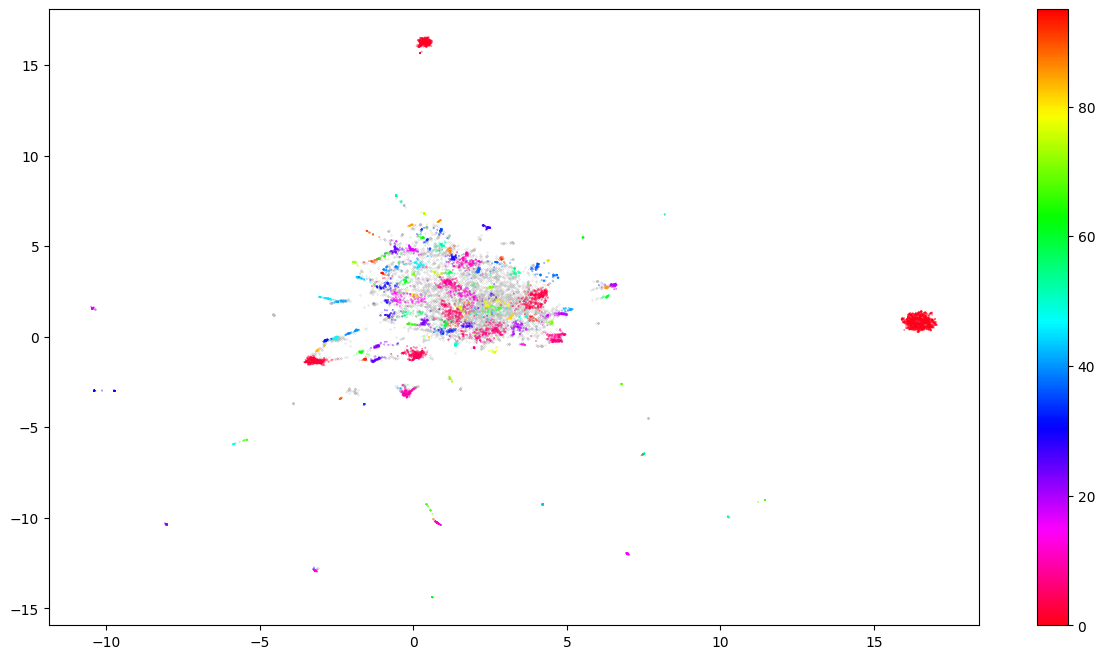

In [ ]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_classic)
result = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
result['labels'] = topics

fig, ax = plt.subplots(figsize=(15, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
topic_model_classic.visualize_documents(df_classic_norm, topics = [1, 2, 3, 4, 5, 6, 7], reduced_embeddings=reduced_embeddings, hide_annotations=False)

In [ ]:
bertopic_analysis(topic_model_classic, df_classic_norm, df_classic_sentences2, nr_repr_docs=20)


Когерентность тематик модели: 0.4295323467631631



KeyError: "['CustomName'] not in index"

## Topic Modeling of Modern Therapists

In [ ]:
%%time
#https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.visualize_hierarchy

topic_model_modern = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  calculate_probabilities=True

)

# Train model
topics, probs = topic_model_modern.fit_transform(df_modern_norm, embeddings_modern)

2025-01-27 13:25:11,744 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-27 13:25:57,602 - BERTopic - Dimensionality - Completed ✓
2025-01-27 13:25:57,606 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-27 13:26:06,881 - BERTopic - Cluster - Completed ✓
2025-01-27 13:26:06,890 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 112/112 [01:16<00:00,  1.47it/s]
2025-01-27 13:28:47,493 - BERTopic - Representation - Completed ✓


CPU times: user 2min 17s, sys: 12.3 s, total: 2min 30s
Wall time: 3min 36s


In [ ]:
'''
# Renaming the topics according to ChatGPT
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in topic_model_modern.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Выбросы"
topic_model_modern.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels
'''

In [ ]:
# Сохраним модель
#topic_model_modern.save("/content/drive/MyDrive/Therapist_sessions/topic_model_modern_therapist", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
topic_model_modern = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/topic_model_modern_therapist")

2025-04-05 11:17:08,101 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


In [ ]:
topic_model_modern.visualize_topics(title='Modern Therapists')

In [ ]:
topic_model_modern.visualize_hierarchy(custom_labels=True)

In [ ]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_modern)

In [ ]:
topic_model_modern.visualize_documents(df_modern_norm, topics = [1, 2, 3, 4, 5, 6, 7], reduced_embeddings=reduced_embeddings, hide_annotations=False)

In [ ]:
topic_model_modern.get_topic_info().iloc[1]

In [ ]:
bertopic_analysis(topic_model_modern, df_modern_norm, df_modern_sentences2, nr_repr_docs=20)

## Topic merging

In [ ]:
len([0, 1, 2, 10, 11, 11, 13, 15, 16, 19, 21, 31, 34, 35, 39, 43,43, 48, 51, 52, 53, 54, 56, 60, 64, 67, 68, 75, 84, 85, 89, 90, 92, 94])

34

### Classical Therapists

In [ ]:
topics_to_merge = [[0, 1, 2, 10, 11, 11, 13, 15, 16, 19, 21, 31, 34, 35, 39, 43,43, 48, 51, 52, 53, 54, 56, 60, 64, 67, 68, 75, 84, 85, 89, 90, 92, 94],
                   [9, 27, 41, 45],
                   [17, 64, 74],
                   [44, 73],
                   [76, 88],
                   [55, 77],
                   [70, 78, 80]]

topic_model_classic.merge_topics(df_classic_norm, topics_to_merge)

100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


In [ ]:
# saving the model
#topic_model_classic.save("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_classic_therapist", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
#topic_model_classic = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_classic_therapist")

In [ ]:
'''
# Renaming the topics in accordance with ChatGPT.
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in topic_model_classic.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Outliers"
chatgpt_topic_labels[0] = "0_Others"
topic_model_classic.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels
'''

In [ ]:
topic_model_classic.visualize_topics()

In [ ]:
topic_model_classic.visualize_hierarchy(custom_labels=True)

In [ ]:
bertopic_analysis(topic_model_classic, df_classic_norm, df_classic_sentences2, nr_repr_docs=20)

### Modern Therapists

In [ ]:
topics_to_merge = [[0, 3, 4, 9, 34, 38, 40, 41, 49, 50, 52, 58, 61, 62, 63, 64, 67, 68, 71, 79, 80, 84, 87, 89, 90, 97, 98, 103, 104, 105, 106],
                   [6, 11],
                   [17, 56],
                   [33, 60],
                   [15, 26],
                   [18, 27]]
topic_model_modern.merge_topics(df_modern_norm, topics_to_merge)

100%|██████████| 77/77 [00:42<00:00,  1.82it/s]


In [ ]:
'''
# Renaming the topics according to ChatGPT
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in topic_model_modern.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Outliers"
chatgpt_topic_labels[0] = "0_Others"
topic_model_modern.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels
'''

In [ ]:
# saving the model
#topic_model_modern.save("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_modern_therapist", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
#topic_model_modern = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_modern_therapist")

In [ ]:
topic_model_modern.visualize_topics()

In [ ]:
topic_model_modern.visualize_hierarchy(custom_labels=True)

In [ ]:
bertopic_analysis(topic_model_modern, df_modern_norm, df_modern_sentences2, nr_repr_docs=20)

## Topic merging 2

### Classical Therapists

In [ ]:
topics_to_merge = [[8, 45],
                   [39, 2],
                   [40, 20],
                   [23, 15, 53],
                   [17, 36],
                   [10, 7],
                   [0,1, 48, 44, 51,37]]

topic_model_classic.merge_topics(df_classic_norm, topics_to_merge)

In [ ]:
# saving the model
#topic_model_classic.save("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_classic_therapist2", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
topic_model_classic = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_classic_therapist2", embedding_model=embedding_model) #paraphrase-multilingual-MiniLM-L12-v2'

In [ ]:
topic_model_classic.get_topic_info()

Topic  Count                                               Name  \
0      -1   6134                                  -1_you_that_it_to   
1       0   3827                              0_mhm_mhm mhm_her_she   
2       1    355                             1_we_time_our_our time   
3       2    302                               2_he_him_his_that he   
4       3    274                               3_do_not_do not_want   
5       4    215                                  4_you_to_that_the   
6       5    212                                 5_you_that_in_feel   
7       6    200                          6_fear_afraid_the fear_of   
8       7    175                      7_see_see see_mhm see_see mhm   
9       8    157                   8_what you_saying_that what_what   
10      9    118                          9_away_away from_leave_it   
11     10    105                     10_not know_not quite_sure_not   
12     11     99                            11_tell me_tell_me_talk   
13     12     85                   12_hurt_pain_bitterness_the hurt   
14     13     80                              13_blame_for_you_feel   
15     14     79                14_world_intellectual_the world_the   
16     15     78  15_relationship_the relationship_relationships...   
17     16     71                     16_learn_to learn_learning_you   
18     17     68                        17_women_woman_men_feminine   
19     18     67                   18_change_to change_changes_past   
20     19     63                         19_love_person_somebody_to   
21     20     63  20_different_something_is something_contradictory   
22     21     61              21_mother_your mother_your_mother and   
23     22     56  22_satisfaction_satisfactions_happiness_the sa...   
24     23     52                    23_voice_hear_the voice_did not   
25     24     52                  24_too_too much_too strongly_hard   
26     25     51                  25_shaking_can not_throat_choking   
27     26     50                      26_childhood_childish_age_old   
28     27     49                           27_time_your time_you_to   
29     28     48                          28_cry_tears_the tears_if   
30     29     47                     29_father_your_your father_dad   
31     30     47                 30_possible_might_that would_would   
32     31     46                        31_struggle_you_it_you feel   
33     32     45                       32_goal_goals_the goal_reach   
34     33     36                            33_job_work_the_to work   
35     34     34           34_marriage_husband_your husband_married   
36     35     30     35_experience_own experience_experienced_about   
37     36     30                        36_test_exams_exam_the exam   
38     37     27                      37_anger_angry_rage_anger and   
39     38     25    38_question_the question_asking_asking yourself   
40     39     24          39_girl_little girl_little_naughty little   
41     40     24                40_alone_let me_alone you_aloneness   
42     41     23                              41_two_sides_both_one   
43     42     21                          42_sexual_sex_life_normal   
44     43     20                              43_worse_dirty_you_it   

                                           CustomName  \
0                                         -1_Outliers   
1                                            0_Others   
2                    1_Time Management and Scheduling   
3                       2_Complex Emotions Toward Him   
4                            3_Desires and Reluctance   
5                    4_Personal Growth and Challenges   
6             5_Self-Acceptance and Confidence Issues   
7                      6_Exploring the Nature of Fear   
8               7_Understanding the Concept of Seeing   
9               8_Clarifying Meaning in Conversations   
10                       9_Desire to Escape and Leave   
11                  10_Uncertainty and Clarity Issues

In [ ]:
topic_name_dict = {-1: ' -1_Outliers',
 0: ' 0_Others',
 1: ' 1_Time Management and Scheduling',
 2: ' 2_Complex Emotions Toward Him',
 3: ' 3_Desires and Reluctance',
 4: ' 4_Personal Growth and Challenges',
 5: ' 5_Self-Acceptance and Confidence Issues',
 6: ' 6_Exploring the Nature of Fear',
 7: ' 7_Understanding the Concept of Seeing',
 8: ' 8_Clarifying Meaning in Conversations',
 9: ' 9_Desire to Escape and Leave',
 10: ' 10_Uncertainty and Clarity Issues',
 11: ' 11_Open Conversations About Feelings',
 12: ' 12_Exploring Hurt and Bitterness',
 13: ' 13_Guilt and Self-Blame Dynamics',
 14: ' 14_Intellectual Disconnection and Existence',
 15: ' 15_Complexities of Relationships',
 16: ' 16_Personal Journey of Learning',
 17: ' 17_Gender Roles and Relationships',
 18: ' 18_Struggles with Personal Change',
 19: ' 19_Exploring Love and Self-Acceptance',
 20: ' 20_Perceived Differences and Contradictions',
 21: ' 21_Mother-Daughter Relationship Dynamics',
 22: ' 22_Pursuit of Personal Satisfaction',
 23: ' 23_Voice Perception and Despair',
 24: ' 24_Handling Difficult Dilemmas and Emotions',
 25: ' 25_Breathing Struggles and Shaking',
 26: ' 26_Aging and Childhood Reflection',
 27: ' 27_Struggles with Time Management',
 28: ' 28_Crying and Emotional Release',
 29: ' 29_Father-Child Relationships and Authority',
 30: ' 30_Possibilities and Potential Outcomes',
 31: ' 31_Inner Struggle and Helplessness',
 32: ' 32_Understanding Personal Goals and Satisfaction ',
 33: ' 33_Fear and Anxiety About Work',
 34: ' 34_Marriage Doubts and Dependence',
 35: ' 35_Personal Experience Reflection',
 36: ' 36_Exam Results and Personal Reflection',
 37: ' 37_Understanding and Expressing Anger',
 38: ' 38_Self-Reflection and Questioning',
 39: ' 39_Embracing the Inner Child',
 40: ' 40_Emotional Aloneness and Independence',
 41: ' 41_Dual Perspectives and Polarities',
 42: ' 42_Sexual Satisfaction and Relationships',
 43: ' 43_Struggles with Self-Perception'}

In [ ]:
topic_model_classic.set_topic_labels(topic_name_dict)
topic_model_classic

In [ ]:
topic_model_classic.visualize_topics()

In [ ]:
topic_model_classic.visualize_hierarchy(custom_labels=True,title='<b>Hierarchical clustering of classical therapist remarks <b>')

In [ ]:
plot_results = pd.DataFrame(embeddings_classic)

plot_results['text'] = df_classic_norm
plot_results['topics'] = topic_model_classic.topics_

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(plot_results[~plot_results.topics.isin([-1,0])].drop(['topics','text'], axis=1))
result = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
result['labels'] = list(plot_results[~plot_results.topics.isin([-1,0])]['topics'])

In [ ]:
labels = np.array(plot_results[~plot_results.topics.isin([-1,0])]['topics'])
labels = [topic_name_dict.get(item, item) for item in labels]

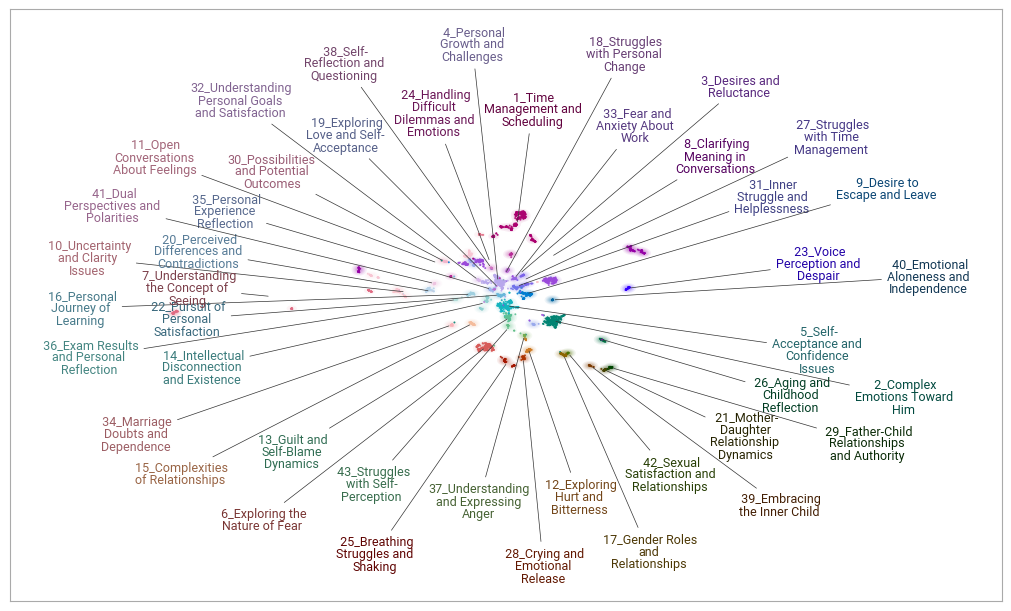

In [ ]:
fig, ax = datamapplot.create_plot(reduced_embeddings, labels, label_over_points=False, dynamic_label_size=False, figsize=(10, 6), label_font_size=9, point_size=2)

In [ ]:
bertopic_analysis(topic_model_classic, df_classic_norm, df_classic_sentences2, nr_repr_docs=20)


Когерентность тематик модели: 0.4770315724921208


Краткая информации о тематиках:

    |   Topic |   Count | OpenAI_name                                       | BERTopic_ame
----+---------+---------+---------------------------------------------------+------------------------------------------------------------------
  0 |      -1 |    6134 | -1_Outliers                                       | -1_you_that_it_to
  1 |       0 |    3827 | 0_Others                                          | 0_mhm_mhm mhm_her_she
  2 |       1 |     355 | 1_Meeting Time Confirmation                       | 1_we_time_our_our time
  3 |       2 |     302 | 2_Complex Feelings Toward Him                     | 2_he_him_his_that he
  4 |       3 |     274 | 3_Desires and Avoidances                          | 3_do_not_do not_want
  5 |       4 |     215 | 4_Personal Growth and Self-Reflection             | 4_you_to_that_the
  6 |       5 |     212 | 5_Self-Confidence in Relationships                | 5_you_that_

### Modern Therapists

In [ ]:
topics_to_merge = [[0,1,53,48,9,39,46,67,66,11,65,15,45,8,70,63,13,69,47,43,61,71,7,38,60,56,42,1,2],
                   [33, 31],
                   [44, 26]]
topic_model_modern.merge_topics(df_modern_norm, topics_to_merge)

100%|██████████| 48/48 [00:28<00:00,  1.68it/s]


In [ ]:
# Renaming the topics according to ChatGPT
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in topic_model_modern.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Outliers"
chatgpt_topic_labels[0] = "0_Others"
topic_model_modern.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels

{-1: '-1_Outliers',
 0: '0_Others',
 1: '1_Emotional Reactions and Feelings',
 2: '2_Job Search and Work Challenges',
 3: '3_Collaborative Work and Support',
 4: '4_Weekly Planning and Meeting Ideas',
 5: "5_Discovering Your Life's Purpose",
 6: '6_Therapy and Father Relationships',
 7: '7_Navigating Complexity in Relationships',
 8: '8_Exploring Communication Tools and Techniques',
 9: '9_Family Dynamics and Identity',
 10: '10_Self-Talk and Self-Care Strategies',
 11: '11_Expressions of Happiness and Joy',
 12: '12_Breathing and Meditation Techniques',
 13: '13_School Transition Experiences and Challenges',
 14: '14_Healing Journey and Recovery Stages',
 15: '15_Mother-Daughter Relationship Issues',
 16: '16_Returning to the Past',
 17: '17_Questions and Answers Discussion',
 18: '18_Thoughts and Reflection Process',
 19: '19_Alcohol Consumption and Relationships',
 20: '20_Navigating Pain and Discomfort',
 21: '21_Understanding and Managing Anxiety',
 22: '22_Managing Energy Levels 

In [ ]:
# saving the model
#topic_model_modern.save("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_modern_therapist", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
topic_model_modern = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/merged_topic_model_modern_therapist", embedding_model=embedding_model)

In [ ]:
topic_name_dict = {-1: '-1_Outliers',
 0: '0_Others',
 1: '1_Emotional Feelings and Connections',
 2: '2_Job Search and Work Challenges',
 3: '3_Collaborative Problem Solving Approach',
 4: '4_Weekly Planning and Meetings',
 5: "5_Discovering Your True Desires",
 6: '6_Therapy and Father Relationships',
 7: '7_Navigating Complex Friendships',
 8: '8_Exploring Communication Tools and Techniques',
 9: '9_Family Dynamics and Identity',
 10: '10_Self Talk and Self Care',
 11: '11_Expressions of Happiness and Joy',
 12: '12_Breathing and Meditation Practices',
 13: '13_School Transitions and Experiences',
 14: '14_Stages of Healing Recovery',
 15: '15_Relationship with Your Mom',
 16: '16_Returning to the Past',
 17: '17_Final Questions and Clarifications',
 18: '18_Thoughts and Mind Exploration',
 19: '19_Alcohol Consumption and Consequences',
 20: '20_Understanding and Managing Pain',
 21: '21_Understanding Anxiety Triggers',
 22: '22_Managing and Increasing Energy',
 23: '23_Age and Generational Perspectives',
 24: '24_Safety and Self-Protection Insights',
 25: '25_Understanding Chronic Depression Dynamics',
 26: '26_Shadows of Reflexive Experience',
 27: '27_Understanding Progress and Recovery',
 28: '28_Navigating Fear and Concerns',
 29: '29_Managing and Understanding Anger',
 30: '30_Nervous System and Stress Response',
 31: '31_Control and Behavioral Strategies',
 32: '32_Possibilities and Uncertainties',
 33: '33_Flexible Thinking and Mindfulness',
 34: '34_Stomach Feelings and Tension',
 35: '35_Memory Processing and Reprocessing',
 36: '36_Weather and Storm Descriptions',
 37: '37_Listening to Your Body',
 38: '38_Understanding Mistakes and Consequences',
 39: '39_Self-Criticism and Social Dynamics',
 40: '40_Goal Setting and Achievement',
 41: '41_Processes of Stopping and Disconnecting',
 42: '42_Navigating Difficult Situations',
 43: '43_Love Songs and Voice Exploration ',
 44: '44_Personal vs. Societal Comparison',
 45: '45_Inquiry and Information Seeking',
 46: '46_Effective Communication Strategies'}

topic_model_modern.set_topic_labels(topic_name_dict)

In [ ]:
topic_model_modern.get_topic_info()

Topic  Count                                           Name  \
0      -1   5278                              -1_you_to_the_and   
1       0   4117                            0_she_not_okay_that   
2       1    264                1_feel_feeling_you feel_emotion   
3       2    179                          2_job_work_you_income   
4       3    174                     3_we_we can_we are_we have   
5       4    167                  4_week_time_minutes_next week   
6       5    112                         5_do_want_you_you want   
7       6    108               6_therapy_dad_therapist_your dad   
8       7    106    7_relationship_friend_friends_relationships   
9       8    102                        8_say_you say_you_tools   
10      9    102           9_family_your family_the family_your   
11     10     90         10_yourself_self_to yourself_self talk   
12     11     85                         11_happy_like_glad_joy   
13     12     85             12_breathing_meditation_breath_you   
14     13     83             13_school_third_college_the school   
15     14     82                     14_recovery_healing_of_the   
16     15     81                    15_mom_your mom_your_mother   
17     16     77                     16_back_go back_back to_go   
18     17     75            17_questions_any_any questions_quiz   
19     18     74          18_thought_think about_about_thinking   
20     19     73              19_drinking_alcohol_drink_you are   
21     20     70              20_pain_painful_symptoms_the pain   
22     21     64            21_anxiety_of anxiety_when_when you   
23     22     60             22_energy_the energy_the_of energy   
24     23     57             23_old_how old_generations_old you   
25     24     49                          24_safe_safety_you_of   
26     25     48   25_depression_depressed_depression and_right   
27     26     48                            26_it_it is_like_is   
28     27     47               27_progress_progress that_we_the   
29     28     46              28_fear_the fear_afraid_afraid of   
30     29     43            29_angry_anger_your anger_anger and   
31     30     41  30_nervous system_nervous_system_your nervous   
32     31     32            31_control_can_behavioral_behaviors   
33     32     32            32_possibility_maybe_probably_might   
34     33     31                    33_thinking_mind_logical_of   
35     34     31           34_stomach_your stomach_your_side of   
36     35     30             35_memory_memories_target_bring up   
37     36     30               36_weather_wet_the weather_storm   
38     37     29                37_body_your body_your_body and   
39     38     29          38_mistake_mistakes_make mistake_make   
40     39     29                   39_they_themselves_people_of   
41     40     27               40_goal_goals_your goal_oriented   
42     41     27                41_stop_shut_disconnect_stopped   
43     42     23                   42_difficult_hard_it is_easy   
44     43     21                        43_song_voice_can_songs   
45     44     21       44_comparison_comparing_compare_personal   
46     45     20                  45_tell me_tell_me_about that   
47     46     20             46_communication_they_the one_them   

                                       Representation  \
0       [you, to, the, and, that, of, it, is, in, so]   
1   [she, not, okay, that, is, you, to, yeah, he, ...   
2   [feel, feeling, you feel, emotion, you, how, e...   
3   [job, work, you, income, that, working, to, yo...   
4   [we, we can, we are, we have, to, we will, let...   
5   [week, time, minutes, next week, this week, ne...   
6   [do, want, you, you want, to do, need, do that...   
7   [therapy, dad, therapist, your dad, counseling...   
8   [relationship, friend, friends, relationships,...   
9   [say, you say, you, tools, what, to say, syste...   
10  [family, your family, the family, your, the, f...   
11  [yourself, self, to yourself, se

In [ ]:
topic_model_modern.visualize_topics()

In [ ]:
topic_model_modern.visualize_hierarchy(custom_labels=True, title='<b>Hierarchical clustering of modern therapist remarks <b>')

In [ ]:
df_modern_sentences3 = pd.DataFrame(df_modern_sentences2)
df_modern_sentences3['topics'] = topic_model_modern.topics_
df_modern_sentences3['topic_name'] = df_modern_sentences3['topics'].replace(topic_name_dict)
df_modern_sentences3

0  topics  \
0        I know when we met last time for your intake.        -1   
1            You were concerned about some presentation.      -1   
2                          So you had to give at school.      13   
3                     You want to talk about that today?       0   
4      A timer for like recently when you had to get ...       4   
...                                                  ...     ...   
12514   So kind of there's something very real about it.      -1   
12515  We sometimes have to be on these processes and...      -1   
12516  and you know felt no conversations with you al...       0   
12517                                              Okay.       0   
12518       Thank you so much and wish you all the best.       0   

                                  topic_name  
0                                -1_Outliers  
1                                -1_Outliers  
2      13_School Transitions and Experiences  
3                                   0_Others  
4             4_Weekly Planning and Meetings  
...                                      ...  
12514                            -1_Outliers  
12515                            -1_Outliers  
12516                               0_Others  
12517                               0_Others  
12518                               0_Others  

[12519 rows x 3 columns]

In [ ]:
df_modern_sentences3.to_excel('df_modern_sentences3.xlsx')

In [ ]:
bertopic_analysis(topic_model_modern, df_modern_norm, df_modern_sentences2, nr_repr_docs=20)


Когерентность тематик модели: 0.4312618529708102


Краткая информации о тематиках:

    |   Topic |   Count | OpenAI_name                                      | BERTopic_ame
----+---------+---------+--------------------------------------------------+-----------------------------------------------
  0 |      -1 |    5278 | -1_Outliers                                      | -1_you_to_the_and
  1 |       0 |    4117 | 0_Others                                         | 0_she_not_okay_that
  2 |       1 |     264 | 1_Emotional Feelings and Connections             | 1_feel_feeling_you feel_emotion
  3 |       2 |     179 | 2_Job Search and Work Challenges                 | 2_job_work_you_income
  4 |       3 |     174 | 3_Collaborative Work and Support                 | 3_we_we can_we are_we have
  5 |       4 |     167 | 4_Weekly Meeting Plans                           | 4_week_time_minutes_next week
  6 |       5 |     112 | 5_exploring desires and actions                  | 5_do_want_you

## Comparison of Topic Models

#### Closest topics by cosine similarity

Function for retrieving the three closest topics based on cosine similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def similar_topics_finder (model1, model2, model1_topic, number_topics_model2):
    sim_matrix = cosine_similarity(model1.topic_embeddings_, model2.topic_embeddings_)
    print(f'Topic number of the first model:{model1_topic}')
    print([x[0] for x in model1.get_topic(model1_topic)])
    print()

    topic = model1_topic
    top_indices = np.argsort(sim_matrix[topic + 1])[::-1][:number_topics_model2]
    print(f'Closest topics of the second model":')
    for i in  top_indices:
        print()
        print(f'Тематика {i-1} (Cos_sim={np.round(sim_matrix[topic + 1][i],3)}):' ,  [x[0] for x in model2.get_topic(i-1)])

In [ ]:
similar_topics_finder (topic_model_classic, topic_model_modern, model1_topic=6, number_topics_model2=3)

Номер тематики первой модели :6
['fear', 'afraid', 'the fear', 'of', 'of fear', 'the', 'fear of', 'afraid of', 'you', 'risk']

Ближайщие тематики второй модели:

Тематика 28 (Cos_sim=0.949999988079071): ['fear', 'the fear', 'afraid', 'afraid of', 'worried', 'concern', 'about', 'the', 'worry', 'little concerned']

Тематика 21 (Cos_sim=0.7649999856948853): ['anxiety', 'of anxiety', 'when', 'when you', 'that', 'of', 'the', 'panic', 'you', 'up']

Тематика 24 (Cos_sim=0.656000018119812): ['safe', 'safety', 'you', 'of', 'protectors', 'protect', 'to', 'the', 'that', 'protecting']


Cosine Similarity Table for Related Topics:

In [ ]:
# The topics -1 and 0 have been removed from the cosine proximity matrix.

from sklearn.metrics.pairwise import cosine_similarity

def similar_topic_model2 (model1, model2, model1_topic):
    sim_matrix = cosine_similarity(model1.topic_embeddings_[2:], model2.topic_embeddings_[2:])

    return np.argmax(sim_matrix[model1_topic - 1])+1, np.round(np.max(sim_matrix[model1_topic - 1]),3)


In [ ]:
def df_similar_topics (model1, model2):
    df = pd.DataFrame(columns=['Topic_model1',
                               'Name_model1',
                               'Top_words_model1',
                               'Topic_model2',
                               'Name_model2',
                               'Top_words_model2',
                               'Cosine_similatity'])

    #for i in model1.get_topics():
    for i in range(1, len(model1.get_topics())-1):
        sim_topic = similar_topic_model2(model1, model2, i)
        topic_list = []
        #print(i,sim_topic[0])
        topic_list.append(f'Topic_{i}')
        topic_list.append(model1.get_topic_info(i)['CustomName'][0])
        topic_list.append([x[0] for x in model1.get_topic(i)])
        topic_list.append(f'Topic_{sim_topic[0]}')
        topic_list.append(model2.get_topic_info(sim_topic[0])['CustomName'][0])
        topic_list.append([x[0] for x in model2.get_topic(sim_topic[0])])
        topic_list.append(sim_topic[1])
        df_topic = pd.DataFrame([topic_list], columns=df.columns)
        df = pd.concat([df, df_topic], ignore_index=True)

    return df

In [ ]:
df_similar_topics = df_similar_topics(topic_model_classic, topic_model_modern)
df_similar_topics.to_excel('/content/drive/MyDrive/Therapist_sessions/classic_Modern_Eng_sessions/Cos_sim_classic_modern.xlsx', index=False)
df_similar_topics

Topic_model1                                        Name_model1  \
0       Topic_1                   1_Time Management and Scheduling   
1       Topic_2                      2_Complex Emotions Toward Him   
2       Topic_3                           3_Desires and Reluctance   
3       Topic_4                   4_Personal Growth and Challenges   
4       Topic_5            5_Self-Acceptance and Confidence Issues   
5       Topic_6                     6_Exploring the Nature of Fear   
6       Topic_7              7_Understanding the Concept of Seeing   
7       Topic_8              8_Clarifying Meaning in Conversations   
8       Topic_9                       9_Desire to Escape and Leave   
9      Topic_10                  10_Uncertainty and Clarity Issues   
10     Topic_11               11_Open Conversations About Feelings   
11     Topic_12                   12_Exploring Hurt and Bitterness   
12     Topic_13                   13_Guilt and Self-Blame Dynamics   
13     Topic_14        14_Intellectual Disconnection and Existence   
14     Topic_15                   15_Complexities of Relationships   
15     Topic_16                    16_Personal Journey of Learning   
16     Topic_17                  17_Gender Roles and Relationships   
17     Topic_18                  18_Struggles with Personal Change   
18     Topic_19              19_Exploring Love and Self-Acceptance   
19     Topic_20        20_Perceived Differences and Contradictions   
20     Topic_21           21_Mother-Daughter Relationship Dynamics   
21     Topic_22                22_Pursuit of Personal Satisfaction   
22     Topic_23                    23_Voice Perception and Despair   
23     Topic_24        24_Handling Difficult Dilemmas and Emotions   
24     Topic_25                 25_Breathing Struggles and Shaking   
25     Topic_26                  26_Aging and Childhood Reflection   
26     Topic_27                  27_Struggles with Time Management   
27     Topic_28                    28_Crying and Emotional Release   
28     Topic_29        29_Father-Child Relationships and Authority   
29     Topic_30            30_Possibilities and Potential Outcomes   
30     Topic_31                 31_Inner Struggle and Helplessness   
31     Topic_32   32_Understanding Personal Goals and Satisfact...   
32     Topic_33                     33_Fear and Anxiety About Work   
33     Topic_34                  34_Marriage Doubts and Dependence   
34     Topic_35                  35_Personal Experience Reflection   
35     Topic_36            36_Exam Results and Personal Reflection   
36     Topic_37              37_Understanding and Expressing Anger   
37     Topic_38                 38_Self-Reflection and Questioning   
38     Topic_39                       39_Embracing the Inner Child   
39     Topic_40            40_Emotional Aloneness and Independence   
40     Topic_41                41_Dual Perspectives and Polarities   
41     Topic_42           42_Sexual Satisfaction and Relationships   
42     Topic_43                  43_Struggles with Self-Perception   

                                     Top_words_model1 Topic_model2  \
0   [we, time, our, our time, week, next, see, mon...      Topic_4   
1   [he, him, his, that he, you, that, to, and, fe...     Topic_10   
2   [do, not, do not, want, not want, you do, want...      Topic_5   
3   [you, to, that, the, of, in, that you, and, it...     Topic_33   
4   [you, that, in, feel, you feel, to, confidence...     Topic_39   
5   [fear, afraid, the fear, of, of fear, the, fea...     Topic_28   
6   [see, see see, mhm see, see mhm, let, let is, ...     Topic_45   
7   [what you, saying, that what, what, are saying...      Topic_8   
8   [away, away from, leave, it, you, from, to, ou...      Topic_3   
9   [not know, not quite, sure, not, quite, am not...     Topic_26   
10  [tell me, tell, me, talk, appreciate, to talk,...     Topic_45   
11  [hurt, pain, bitterness, the hurt, of, and, it...     Topic_20   
12  [blame, 

#### Heatmap of topic similarity

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

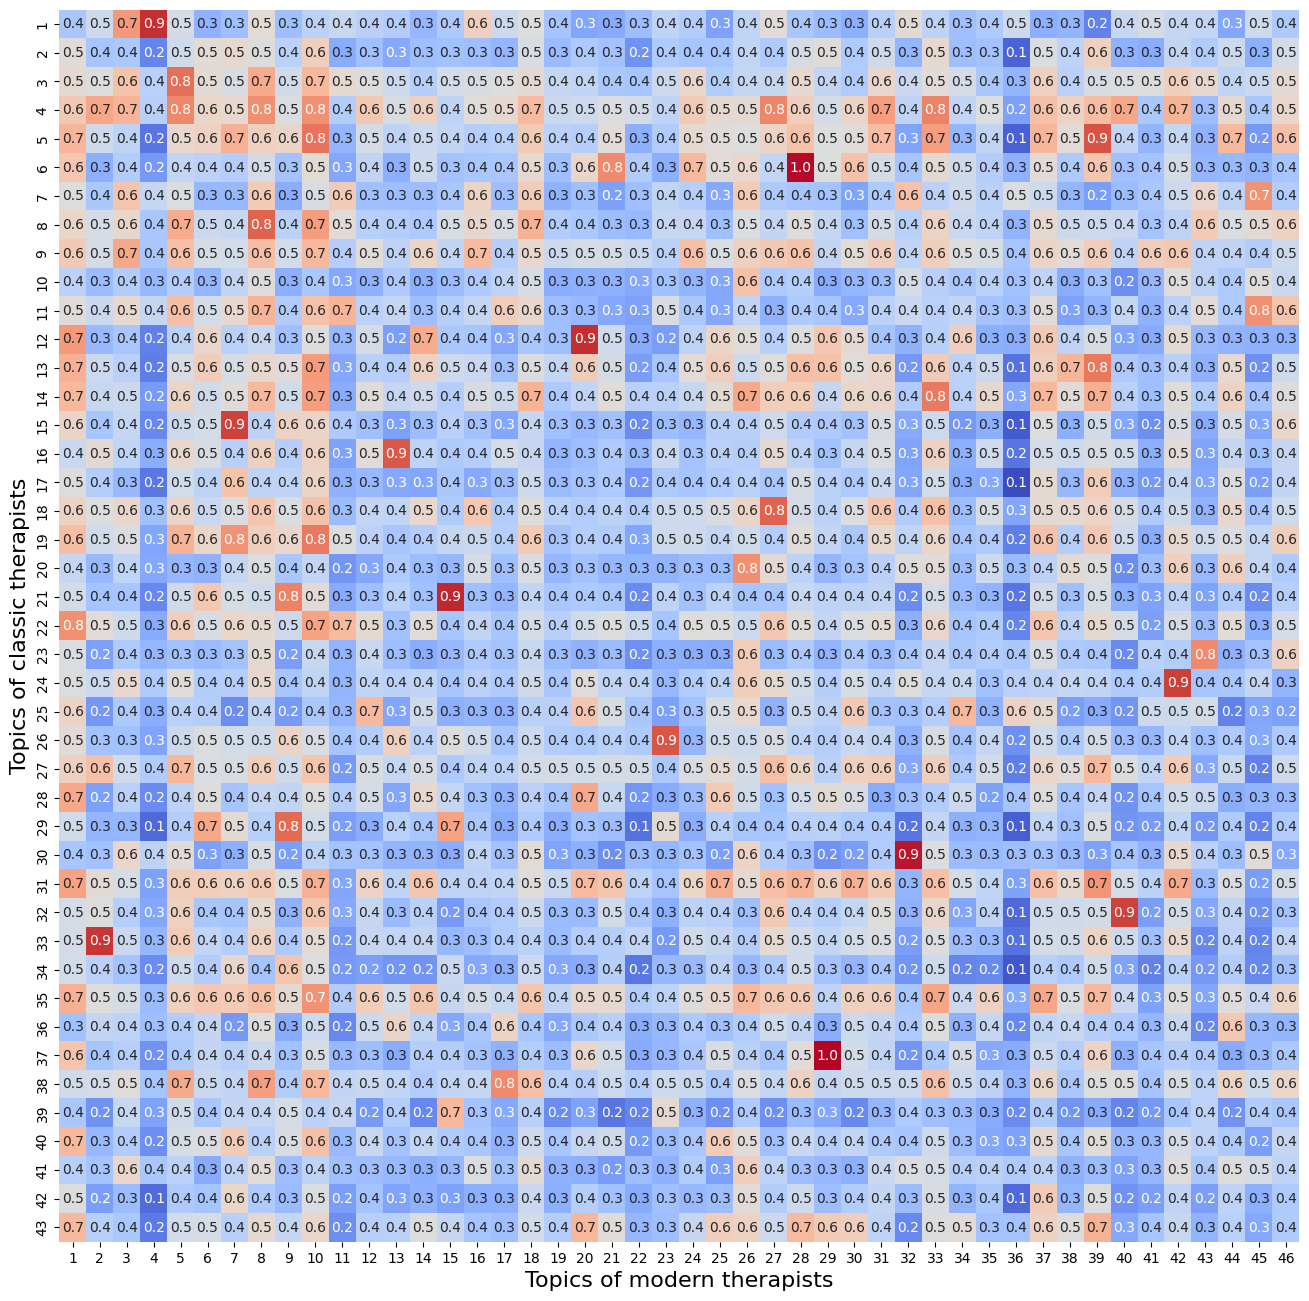

In [ ]:
plt.figure(figsize=(16, 16))

sim_matrix = cosine_similarity(topic_model_classic.topic_embeddings_[2:], topic_model_modern.topic_embeddings_[2:])

sns.heatmap(sim_matrix,
            annot=True,
            annot_kws = {'fontsize':10},
            cmap='coolwarm',
            fmt='.1f',
            cbar=False,
            xticklabels=range(1, sim_matrix.shape[1]+1),
            yticklabels=range(1, sim_matrix.shape[0]+1))
#plt.title('Cosine Proximity Heatmap', fontsize=1)
plt.xlabel('Topics of modern therapists', fontsize=16)
plt.ylabel('Topics of classic therapists', fontsize=16)
plt.savefig('Figure 2.jpg', format='jpg')
plt.show()

In [ ]:
with open('/content/Classic_txt.txt', 'r', encoding='utf-8') as file:
    classic_txt = file.readlines()

In [ ]:
with open('/content/Modern_txt.txt', 'r', encoding='utf-8') as file:
    modern_txt = file.readlines()

In [ ]:
classic_txt = pd.DataFrame([line.strip().split('|') for line in classic_txt])

In [ ]:
modern_txt = pd.DataFrame([line.strip().split('|') for line in modern_txt])

In [ ]:
classic_txt.to_excel('classic_txt.xlsx', index_label=None)

In [ ]:
modern_txt.to_excel('modern_txt.xlsx', index_label=None)

## Combining the themes of two models

---



In [ ]:
merged_model = BERTopic.merge_models([topic_model_classic, topic_model_modern], min_similarity=0.7, embedding_model=embedding_model)

In [ ]:
chatgpt_topic_labels = {topic: f'{topic}_{values[0][0]}' for topic, values in merged_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "-1_Outliers"
chatgpt_topic_labels[0] = "0_Others"
merged_model.set_topic_labels(chatgpt_topic_labels)
chatgpt_topic_labels

{-1: '-1_Outliers',
 0: '0_Others',
 1: '1_Time Up and Future Meetings',
 2: '2_Complex Emotions Toward Him',
 3: '3_Desires and Disappointments',
 4: '4_Personal Growth and Decision-Making',
 5: '5_Self-Acceptance and Relationships',
 6: '6_Understanding and Confronting Fear',
 7: '7_See and Understanding Conversations',
 8: '8_Clarifying Meaning and Intent',
 9: '9_Desire to Escape and Leave',
 10: '10_Uncertainty and Understanding Issues',
 11: '11_Open Conversation and Sharing',
 12: '12_Exploring Emotional Hurt and Bitterness',
 13: '13_Guilt and Self-Blame Dynamics',
 14: '14_Alienation and Intellectual Reflection',
 15: '15_Dynamics of Meaningful Relationships',
 16: '16_Struggles and Desires in Learning',
 17: '17_Gender Roles and Relationships',
 18: '18_Struggles with Personal Change',
 19: '19_Exploring the Nature of Love',
 20: '20_Value Discrepancies and Differences',
 21: '21_Complex Mother-Sibling Relationships',
 22: '22_Pursuit of Inner Satisfaction',
 23: '23_Voices a

In [ ]:
merged_model.get_topic_info()

Topic  Count                                      Name  \
0      -1  11869                         -1_you_that_it_to   
1       0   7944                     0_mhm_mhm mhm_her_she   
2       1    696                    1_we_time_our_our time   
3       2    302                      2_he_him_his_that he   
4       3    386                      3_do_not_do not_want   
..    ...    ...                                       ...   
57     56     30          56_weather_wet_the weather_storm   
58     57     29     57_mistake_mistakes_make mistake_make   
59     58     27           58_stop_shut_disconnect_stopped   
60     59     21  59_comparison_comparing_compare_personal   
61     60     20        60_communication_they_the one_them   

                                    CustomName  \
0                                  -1_Outliers   
1                                     0_Others   
2                1_Time Up and Future Meetings   
3                2_Complex Emotions Toward Him   
4                3_Desires and Disappointments   
..                                         ...   
57            56_Weather and Storm Experiences   
58  57_Understanding Mistakes and Consequences   
59           58_Stop and Disconnect Procedures   
60         59_Personal vs. Societal Comparison   
61       60_Effective Communication Strategies   

                                       Representation  \
0      [you, that, it, to, of, the, and, not, in, do]   
1   [mhm, mhm mhm, her, she, that, the, okay, mhm ...   
2   [we, time, our, our time, week, next, see, mon...   
3   [he, him, his, that he, you, that, to, and, fe...   
4   [do, not, do not, want, not want, you do, want...   
..                                                ...   
57  [weather, wet, the weather, storm, water, rain...   
58  [mistake, mistakes, make mistake, make, consis...   
59  [stop, shut, disconnect, stopped, stop the, do...   
60  [comparison, comparing, compare, personal, mor...   
61  [communication, they, the one, them, signals, ...   

                                              KeyBERT  \
0   [you feel, feeling, feel, feel that, what you,...   
1   [mhm mhm, mhm hum, mhm, mhm yeah, okay mhm, ye...   
2   [our time, time up, the time, see our, time ab...   
3   [him you, for him, him but, that he, to him, h...   
4   [not want, do not, not do, not for, you not, n...   
..                                                ...   
57  [the weather, weather, weather in, the storm, ...   
58  [make mistake, mistake and, mistakes, mistake,...   
59  [stop, you stop, to stop, do stop, stop the, s...   
60  [by comparing, comparing to, comparison to, co...   
61  [communicate and, to communication, communicat...   

                                       OpenAI  \
0     [Self-awareness and emotional struggle]   
1     [Counseling Conversations and Feelings]   
2               [Time Up and Future Meetings]   
3               [Complex Emotions Toward Him]   
4               [Desires and Disappointments]   
..                                        ...   
57            [Weather and Storm Experiences]   
58  [Understanding Mistakes and Consequences]   
59           [Stop and Disconnect Procedures]   
60         [Personal vs. Societal Comparison]   
61       [Effective Communication Strategies]   

                                                  MMR                   POS  \
0   [you, do, feel, but, that you, just, would, yo...  [, , , , , , , , , ]   
1   [her, mhm that, feeling, feel, feelings, couns...  [, , , , , , , , , ]   
2   [time, our time, week, monday, friday, minutes...  [, , , , , , , , , ]   
3   [that he, him and, you feel, would, that you, ...  [, , , , , , , , , ]   
4   [do not, not want, want to, not have, would no...  [, , , , , , , , , ]   
..                                                ...                   ...   
57  [wet, the weather, storm, rain, used, has begi...  [, , , , , , , , , ]   
58  [mistake, mistakes, make mistake, make, consis...  [, , , , , ,

In [ ]:
# saving the model
#merged_model.save("/content/drive/MyDrive/Therapist_sessions/merged_model", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
merged_model = BERTopic.load("/content/drive/MyDrive/Therapist_sessions/merged_model", embedding_model=embedding_model)

2025-01-27 14:53:10,110 - BERTopic - WARNING: The c-TF-IDF matrix could not be saved as it was not found. This typically occurs when merging BERTopic models with `BERTopic.merge_models`.


In [ ]:
merged_model.visualize_topics()

In [ ]:
topic_model_classic.visualize_hierarchy(custom_labels=True)

### Merging datasets

In [ ]:
df_norm = pd.concat([df_classic_norm, df_modern_norm],ignore_index=True)
df_norm.shape

(26244,)

In [ ]:
df_sentences2 = pd.concat([df_classic_sentences2, df_modern_sentences2],ignore_index=True)
df_sentences2.shape

(26244,)

In [ ]:
embeddings = np.concatenate([embeddings_classic, embeddings_modern])
embeddings.shape

(26244, 384)

### Finding topics for the entire dataset

In [ ]:
topics, probs = merged_model.transform(df_norm, embeddings)

2025-01-27 14:07:37,851 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [ ]:
df_with_topics = pd.DataFrame(df_sentences2)
df_with_topics.columns = ['text']
df_with_topics['topics'] = topics
df_with_topics

text  topics
0                             Are you say you're scared?       6
1      But you're smiling at another sleepover, but s...       6
2                                  But you have stage 4.       3
3                       You put your hand on your chest.      54
4                           Play would you like to go?        45
...                                                  ...     ...
26239   So kind of there's something very real about it.      35
26240  We sometimes have to be on these processes and...       4
26241  and you know felt no conversations with you al...      40
26242                                              Okay.       0
26243       Thank you so much and wish you all the best.      11

[26244 rows x 2 columns]

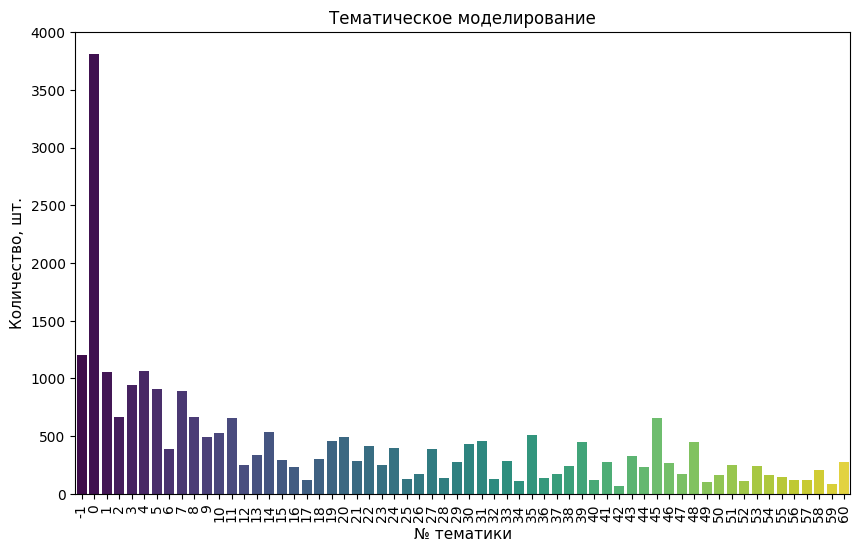

In [ ]:
# Topics' size
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=df_with_topics['topics'].value_counts().index,
                 y=df_with_topics['topics'].value_counts(),
                 hue = df_with_topics['topics'].value_counts().index,
                 palette='viridis',
                 legend=False)
#ax.bar_label(ax.containers[0], fontsize=10)
ax.tick_params(axis='x', rotation=90)
plt.ylabel('Количество, шт.', fontsize=11)
plt.xlabel('№ тематики', fontsize=11)
plt.title('Тематическое моделирование')
plt.show()

In [ ]:
for i in merged_model.get_topic_info().index:
    topic = merged_model.get_topic_info()['Topic'][i]
    print('\033[1m' + f'TOPIC_{topic}' + '\033[0m')
    print('\033[1m' + 'Количество текстов: ' + '\033[1m', df_with_topics[df_with_topics.topics==topic].shape[0])
    print('\033[1m' + 'Название: ' + '\033[1m', merged_model.get_topic_info().CustomName[i])
    print('\033[1m' + 'Ключевые слова:' + '\033[0m', merged_model.get_topic_info().Representation[i])
    print()
    print('\033[1m' + "Релевантные тексты:" + '\033[0m')
    for text in df_with_topics[df_with_topics.topics==topic].sample(20)['text']:
        print(text)
    print()

TOPIC_-1
Количество текстов:  1202
Название:  -1_Outliers
Ключевые слова: ['you', 'that', 'it', 'to', 'of', 'the', 'and', 'not', 'in', 'do']

Релевантные тексты:
If I get that, you've sort of been shaking hands and getting acquainted with your real self, and you find that your real self has some idea about where it wants to go.
But I think that also stands for everything else that's happening.
Now, I'm slowly being disillusioned, because I can see how, after many years, I can see that perhaps that isn't the ultimate end, whereas before there were no two ways about it.   
Okay, so thank the annoyed part for its willingness.
To feeling, no, the only answers are really answers that I find in me.
This is bothering me and the other thing that I think would be a good thing to work on for next time is to maybe you know, the next time that you see the guy that lives next to you.
And you’re not sure whether you can accept that part of yourself that wants to relax and be tired and be sixty-nine.

### Removing outliers

In [ ]:
new_topics = merged_model.reduce_outliers(df_norm, topics, probabilities=probs, strategy="probabilities")

In [ ]:
df_with_new_topics = pd.DataFrame(df_sentences2)
df_with_new_topics.columns = ['text']
df_with_new_topics['topics'] = new_topics

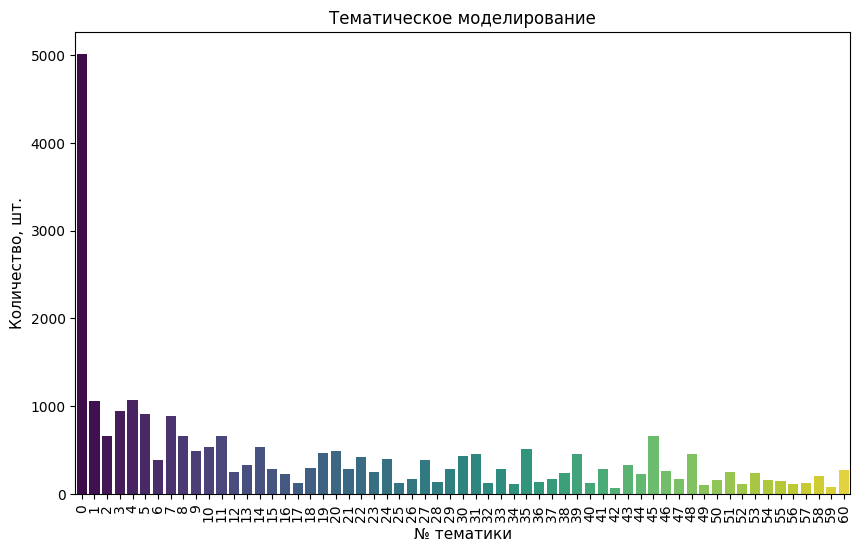

In [ ]:
# Размер кластеров
plt.figure(figsize=(10, 6))

ax = sns.barplot(x=df_with_new_topics['topics'].value_counts().index,
                 y=df_with_new_topics['topics'].value_counts(),
                 hue = df_with_new_topics['topics'].value_counts().index,
                 palette='viridis',
                 legend=False)
#ax.bar_label(ax.containers[0], fontsize=10)
ax.tick_params(axis='x', rotation=90)
plt.ylabel('Количество, шт.', fontsize=11)
plt.xlabel('№ тематики', fontsize=11)
plt.title('Тематическое моделирование')
plt.show()

In [ ]:
for i in merged_model.get_topic_info().index:
    topic = merged_model.get_topic_info()['Topic'][i]
    print('\033[1m' + f'TOPIC_{topic}' + '\033[0m')
    print('\033[1m' + 'Количество текстов: ' + '\033[1m', df_with_new_topics[df_with_new_topics.topics==topic].shape[0])
    print('\033[1m' + 'Название: ' + '\033[1m', merged_model.get_topic_info().CustomName[i])
    print('\033[1m' + 'Ключевые слова:' + '\033[0m', merged_model.get_topic_info().Representation[i])
    print()
    print('\033[1m' + "Релевантные тексты:" + '\033[0m')
    try:
        for text in df_with_topics[df_with_new_topics.topics==topic].sample(20)['text']:
            print(text)
    except:
        print('------------')
    print()

TOPIC_-1
Количество текстов:  0
Название:  -1_Outliers
Ключевые слова: ['you', 'that', 'it', 'to', 'of', 'the', 'and', 'not', 'in', 'do']

Релевантные тексты:
------------

TOPIC_0
Количество текстов:  5012
Название:  0_Others
Ключевые слова: ['mhm', 'mhm mhm', 'her', 'she', 'that', 'the', 'okay', 'mhm that', 'not', 'it']

Релевантные тексты:
Okay.
Okay.
        Uhm, hmm.  
Okay.
  You're not quite to the other extreme, then, but you’re getting close to it.
oh, it’s inappropriate.”
That's right.  
        Uhm, hmm.  
Okay.
        Hmm?
 Uh, huh.
Is there a way to deliver your message, with the same realism that hard without including a face that you feel like it's my fault?
That's right, peaceful.
But anyway, that doesn’t quite catch the present feeling.
        M-hm.  M-hm.  
Yeah.  
Okay.
uh-huh.  
Okay, and as you notice it there how do you feel bored?
and I know this is very familiar to  to see if you can find an appreciation for this one cuz it looks like it worked pretty hard.

T

In [ ]:
df_with_topics.to_excel('df_with_topics.xlsx', index=False)
df_with_new_topics.to_excel('df_with_new_topics.xlsx', index=False)

## Coclusion

This study was conducted to analyze the topics of therapist remarks within a psychotherapeutic context. For this purpose, BERTopic, a powerful ML-based topic modeling technique, was applied to distinguish topics from unstructured dialogue of therapists with their clients within psychotherapy sessions. Topic modeling with a meticulous iterative process of optimizing topic structure based on expert assessment was applied to corpora of therapist remarks from both classical and modern therapeutic approaches, yielding 43 and 46 distinct topics, respectively. Analysis of semantic proximity within these topic sets identified prominent themes in the discourse of both therapist groups, likely reflecting core client concerns. These key topics include fear, anger, anxiety, familial and peer relationships, as well as issues related to development, self-esteem, and other psychological challenges.

More detailed conclusions are presented in the reserach article:
Vanin A, Bolshev V and Panfilova A (2025) Psychotherapist remarks’ ML classifier: insights from LLM and topic modeling application. Front. Psychiatry 16:1608163. doi: 10.3389/fpsyt.2025.1608163

